## Preliminaries

### Packages

In [ ]:
!pip install geopandas
!pip install quantities

<br>
<br>

### Libraries

In [ ]:
import geopandas as gpd
import pandas as pd

import geopy.geocoders
import geopy.extra
import geopy.extra.rate_limiter

import folium
import folium.plugins

import sys
import os
import random
import quantities as pq

<br>
<br>

### Custom Classes

#### For Data

In [ ]:
!rm -rf script.sh && rm -rf monitors && rm -rf toxins
!wget -q https://raw.githubusercontent.com/greyhypotheses/geomatics/develop/script.sh
!bash script.sh

In [ ]:
sys.path.append(os.path.join(os.sep,'content', 'src', 'data'))
sys.path.append(os.path.join(os.sep,'content', 'src', 'files'))

In [ ]:
import data
import files

<br>
<br>

#### For Variables

In [ ]:
class Variables:

    @staticmethod
    def delete(dictionary):
        """
        :params: A dictionary of variable names to be deleted
        """

        for variable in dictionary:
            if str(variable) in globals():
                del variable


<br>
<br>

## Data

### Releases

In [ ]:
blob = 'https://github.com/greyhypotheses/hub/raw/develop/data/countries/us/pa/toxins/release/toxic_release_pennsylvania.zip'
path = 'toxins'
ext = 'shp'
filestring = 'toxic_release_pennsylvania.shp'

releases = data.Data().steps(blob=blob, path=path, ext=ext, filestring=filestring)


In [ ]:
releases.head()

,YEAR,CITY,COUNTY,ST,LATITUDE,LONGITUDE,CHEMICAL,UNIT_OF_ME,TOTAL_RELE,geometry
0,2016,PHILADELPHIA,PHILADELPHIA,PA,40.005901,-75.072103,FORMIC ACID,Pounds,0.160,POINT (2718560.227 256380.179)
1,2016,PHILADELPHIA,PHILADELPHIA,PA,39.920120,-75.146410,ETHYLENE GLYCOL,Pounds,13353.480,POINT (2698674.606 224522.905)
2,2016,PHILADELPHIA,PHILADELPHIA,PA,40.023880,-75.220450,CERTAIN GLYCOL ETHERS,Pounds,104.135,POINT (2676833.394 261701.856)
3,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,LEAD COMPOUNDS,Pounds,1730.280,POINT (2684030.004 221697.388)
4,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,BENZENE,Pounds,39863.290,POINT (2684030.004 221697.388)


<br>

### Air Quality Stations

Foremost, delete variables ...

In [ ]:
Variables().delete({blob, path, ext, filestring})

<br>

The variable names are used again ...

In [ ]:
blob = 'https://github.com/greyhypotheses/hub/raw/develop/data/countries/us/pa/toxins/monitors/PhillyHealth_Air_Monitoring_Stations.zip'
path = 'monitors'
ext = 'shp'
filestring = 'PhillyHealth_Air_Monitoring_Stations.shp'

stations = data.Data().steps(blob=blob, path=path, ext=ext, filestring=filestring)

stations.head()

,SITE_NAME,ADDRESS,BLACK_CARB,ULTRAFINE_,CO,SO2,OZONE,NO2,NOY_NO,PM10,PM2_5,SPECIATED_,PM_COURSE,CARBONYLS,PAMS_VOC,TSP_11101,TSP_METALS,TSP_LEAD,TOXICS_TO1,MET,COMMUNITY_,LATITUDE,LONGITUDE,geometry
0,LAB,1501 East Lycoming Avenue,N,N,Y,N,Y,Y,Y,N,Y,N,N,Y,Y,N,Y,N,y,N,N,40.008606,-75.097624,POINT (2711384.641 257149.310)
1,ROX,Eva and Dearnley Streets,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,Y,N,Y,N,N,40.050461,-75.236966,POINT (2671934.290 271248.900)
2,NEA,Grant Avenue and Ashton Street,N,N,N,N,Y,N,N,N,N,N,N,N,N,N,N,N,N,Y,N,40.072073,-75.013128,POINT (2734326.638 280980.247)
3,CHS,500 South Broad Street,N,N,N,N,N,N,N,N,N,N,N,Y,N,N,Y,N,Y,N,N,39.944510,-75.165442,POINT (2693078.580 233247.101)
4,NEW,2861 Lewis Street,N,N,Y,Y,Y,N,Y,Y,Y,Y,Y,N,N,Y,N,Y,N,Y,N,39.991688,-75.080378,POINT (2716399.773 251134.976)


<br>

Details

In [ ]:
stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SITE_NAME   12 non-null     object  
 1   ADDRESS     12 non-null     object  
 2   BLACK_CARB  12 non-null     object  
 3   ULTRAFINE_  12 non-null     object  
 4   CO          12 non-null     object  
 5   SO2         12 non-null     object  
 6   OZONE       12 non-null     object  
 7   NO2         12 non-null     object  
 8   NOY_NO      12 non-null     object  
 9   PM10        12 non-null     object  
 10  PM2_5       12 non-null     object  
 11  SPECIATED_  12 non-null     object  
 12  PM_COURSE   12 non-null     object  
 13  CARBONYLS   12 non-null     object  
 14  PAMS_VOC    12 non-null     object  
 15  TSP_11101   12 non-null     object  
 16  TSP_METALS  12 non-null     object  
 17  TSP_LEAD    12 non-null     object  
 18  TOXICS_TO1  12 non-null     object  
 19  ME

<br>
<br>

### CRS

In [ ]:
crs = 'epsg:2272'

In [ ]:
if not stations.crs == crs:
    raise Exception('issue')

In [ ]:
if not releases.crs == crs:
    raise Exception('issue')

<br>
<br>

### Units

* https://georepository.com/search/by-name/query//include_world/on/unit_page

In [ ]:
class Descriptions:

    def __init__(self):
        self.name = 'Descriptions'

    @staticmethod
    def axis_info(frame: gpd.GeoDataFrame):

        """
        :params frame: A geopandas.GeoDataFrame whose CRS axes information is of interest.
        """

        axes = frame.crs.axis_info

        for i in range(len(axes)):
            axis = axes[i]
            print('Axis {}: {}, unit code {}'.format(axis.abbrev, axis.unit_name, axis.unit_code))



In [ ]:
Descriptions.axis_info(releases)

Axis X: US survey foot, unit code 9003
Axis Y: US survey foot, unit code 9003


In [ ]:
Descriptions.axis_info(stations)

Axis X: US survey foot, unit code 9003
Axis Y: US survey foot, unit code 9003


<br>
<br>

## Incident & Distances

Randomly select an incident.  Herein, the random number will be an integer between 0 and the height of the releases DataFrame, inclusive; the seed setting ascertains reproducibility.

In [ ]:
random.seed(5)
line: int = random.randint(0, releases.shape[0])

<br>

Hence, a random incident

In [ ]:
incident: gpd.GeoSeries = releases.iloc[line]
incident

YEAR                                                1999
CITY                                        PHILADELPHIA
COUNTY                                      PHILADELPHIA
ST                                                    PA
LATITUDE                                         39.9537
LONGITUDE                                        -75.148
CHEMICAL                                          COPPER
UNIT_OF_ME                                        Pounds
TOTAL_RELE                                          1750
geometry      POINT (2697860.367476776 236725.869933441)
Name: 2092, dtype: object

<br>

The distance of all monitoring stations from the incident (feet)

In [ ]:
distances: gpd.GeoSeries = stations.geometry.distance(incident.geometry)
distances

0     24495.364674
1     43174.079074
2     57343.166673
3      5913.317401
4     23480.457786
5     15712.206064
6      2894.521455
7     32281.044535
8     58777.620992
9     18217.517529
10    20997.998261
11      622.935337
dtype: float64

<br>

Descriptive Statistics

In [ ]:
distances.median()

22239.2280238751

In [ ]:
distances.mean()

25325.852481671947

In [ ]:
distances.skew()

0.6105244470783417

<br>

Smallest distance

In [ ]:
distances.idxmin()

11

In [ ]:
stations.iloc[distances.idxmin]

SITE_NAME                                             VGR
ADDRESS                                      6th and Arch
BLACK_CARB                                              N
ULTRAFINE_                                              N
CO                                                      N
SO2                                                     N
OZONE                                                   Y
NO2                                                     N
NOY_NO                                                  N
PM10                                                    N
PM2_5                                                   Y
SPECIATED_                                              N
PM_COURSE                                               N
CARBONYLS                                               N
PAMS_VOC                                                N
TSP_11101                                               N
TSP_METALS                                              N
TSP_LEAD      

<br>
<br>

## Buffer

The objective herein is to create a radial **2 mile** buffer around each monitoring station.  Foremost, because the unit of measure of the **station** GeoDataFrame is **feet**, the feet equivalent of a mile is required.

<br>

Converting Units

* https://pypi.org/project/Pint/
* https://pypi.org/project/quantities/

In [ ]:
setting = 1 * pq.mile
setting.units = pq.ft

In [ ]:
type(setting.magnitude.take(0))

numpy.float64

<br>

Creating Buffers

In [ ]:
buffer_miles = 2
buffers = stations.geometry.buffer(buffer_miles*setting.magnitude.take(0))

In [ ]:
buffers

0     POLYGON ((2721944.641 257149.310, 2721893.792 ...
1     POLYGON ((2682494.290 271248.900, 2682443.441 ...
2     POLYGON ((2744886.638 280980.247, 2744835.789 ...
3     POLYGON ((2703638.580 233247.101, 2703587.731 ...
4     POLYGON ((2726959.773 251134.976, 2726908.924 ...
5     POLYGON ((2697782.449 225162.647, 2697731.600 ...
6     POLYGON ((2709637.969 239351.837, 2709587.120 ...
7     POLYGON ((2688745.661 211133.454, 2688694.812 ...
8     POLYGON ((2753330.481 274645.396, 2753279.631 ...
9     POLYGON ((2698367.072 221533.464, 2698316.223 ...
10    POLYGON ((2691452.753 249095.833, 2691401.904 ...
11    POLYGON ((2707903.868 236377.621, 2707853.019 ...
dtype: geometry

<br>

Centre of Interest


In [ ]:
geolocator = geopy.geocoders.Nominatim(user_agent='toxin.analysis')
geocode = geopy.extra.rate_limiter.RateLimiter(geolocator.geocode, min_delay_seconds=3)

In [ ]:
# DataFrame
# dataframe['new field name'] = dataframe['query field'].apply(geocode)

# Singular
pinpoint = geolocator.geocode('philadelphia')

<br>

The `pinpoint` variable encodes a number of attributes of interest.  In brief

* address
* altitude
* latitude
* longitude
* point
* raw: This has a set of dictionary keys, i.e., pinpoint.raw.keys(), and the data per key is accessed via pinpoint.raw['key name']


Alternative Approach:
* `gpd.tools.geocode('philadelphia', provider='nominatim', user_agent='toxin.analysis')`

<br>
<br>

<br>

Map

In [ ]:
# A map with release incidents and monitoring stations
m = folium.Map(location=[pinpoint.latitude, pinpoint.longitude], zoom_start=5)

# Add a heatmap to the base map
folium.plugins.HeatMap(data=releases[['LATITUDE', 'LONGITUDE']].values.tolist(), radius=15).add_to(m)


for i, record in stations.iterrows():
    folium.Marker([record['LATITUDE'], record['LONGITUDE']],
                  tooltip='{}, {}'.format(record['SITE_NAME'], record['ADDRESS'])
    ).add_to(m)

# Plot each polygon on the map
style_function = {'color': 'grey'}
if buffers.crs == 4326:
    folium.GeoJson(buffers).add_to(m)
else:
    folium.GeoJson(buffers.to_crs(epsg=4326), overlay=False, smooth_factor=0.05).add_to(m)

# Show the map
m



<br>
<br>

## Multi-Polygon

In [ ]:
# From a group of polygons to single multi-polygon
union_of_buffers = buffers.geometry.unary_union
type(union_of_buffers)

shapely.geometry.multipolygon.MultiPolygon

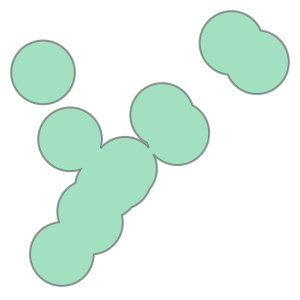

In [ ]:
union_of_buffers

<br>

### Incident & Multi-Polygon

In [ ]:
union_of_buffers.contains(incident.geometry)

True